# COMP47670 Assignment 2: Multi-Class Text Classification
## Description
### Objective
The objective of this assignment is to
- Scrape a corpus of news stories from a set of [web pages](http://mlg.ucd.ie/modules/COMP41680/assignment2/index.html)
- Pre-process the data
- Evaluate the performance of both binary and multi-label text classification algorithms on the data.

### Task 1. Data Collection
1. Select three of the 9 news categories: [Business, Politics, US-News]
2. Retrieve details from the link, parse the HTML to extract the following information:
  - The title of the news story.
  - The short text snippet for the story which represents the start of the complete news article.
  - The category label assigned to the story.
3. Store the parsed data that you have collected in an appropriate format.

In [70]:
import requests
from bs4 import BeautifulSoup
import json
import os.path
import traceback
from termcolor import colored
from glob import glob
from tqdm import tqdm
import pandas as pd
%matplotlib inline

BASE_URL = "http://mlg.ucd.ie/modules/COMP41680/assignment2/month-"
CATEGORIES = ['Business', 'Politics', 'US-News']
MONTHS = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
PAGE_PER_MONTH = 31
NEWS_PAGES_DIR = "./data/raw_data"

The code in the next part indicates a class that is used to scrap, merge, clean, and store the data
from the web page. The data is stored in .json format.

*Note: Through testing, We notice there is no anti-scraping mechanism used on the website, and the time
 of scraping is very short. Therefore, we do not design a breakpoint resume function.*

In [1]:
class NewsScraper:
    def __init__(self):
        self.urls = []
        self.pages_stats = {}
        self.news = []
        self.news_selected = []
        self.news_month = []
        self.news_pages_paths = None

    # formulate the link of months
    def initializer(self):
        for month in MONTHS:
            self.urls.append(BASE_URL + month)

    # web-scraping main
    def pages_scraper(self):
        for url_mon in self.urls:
            page = None
            for page_num in range(1, PAGE_PER_MONTH + 1):
                try:
                    # parse a single page
                    page = self.page_scraper(url_mon, page_num)
                    with open("data/raw_data/{}_{}.json".format(url_mon[-3:], page_num), "w", encoding='utf-8') as f:
                        json.dump(
                            {"page": page},
                            f,
                            indent=4,
                            separators=(',', ': '),
                            sort_keys=False,
                            ensure_ascii=False
                        )
                except Exception as e:
                    print("-" * 30)
                    print(colored("AN ERROR OCCURRED: {}\n".format(e), 'red'))
                print(colored("Finished - Month: {} - page {} with {} news".format(url_mon[-3:], page_num, len(page)), 'green', attrs=['bold']))

                self.pages_stats["{}_{}".format(url_mon[-3:], page_num)] = {"scraped": len(page)}
                self.save_stats()

    # scrap and parse a singe web page
    def page_scraper(self, url_mon, page_num):
        page_news = []
        page_num = str(page_num).zfill(3)
        url = url_mon + "-" + page_num + ".html"
        try:
            try:
                source = requests.get(url, timeout=20)
            except Exception:
                    return

            soup = BeautifulSoup(source.content, features="html.parser")
            for article in soup.find_all("div", class_="article"):
                try:
                    title = article.find("a").text
                except:
                    title = None
                if title == "null":
                    title = None

                try:
                    category = article.find_all(class_ = "metadata")[1].text[10:]
                except:
                    category = None
                if category == "null":
                    category = None

                try:
                    snippet = article.find("p", class_="snippet").text
                except:
                    snippet = None
                if snippet == "null":
                    snippet =None

                news = {
                    "title": title,
                    "category": category,
                    "snippet": snippet
                    # "link": link
                }
                page_news.append(news)
            return page_news

        except Exception as e:
            print("-" * 30)
            print(colored("ERROR: {}\n{}URL: {}".format(e, traceback.format_exc(), url), 'red'))
            return

    # save the status of scraping
    def save_stats(self):
        with open("data/stats/pages_stats.json", "w", encoding='utf-8') as f:
            json.dump(
                self.pages_stats,
                f,
                indent=4,
                separators=(',', ': '),
                sort_keys=False,
                ensure_ascii=False
            )

    # merging process
    def pages_merger(self):
        self.news_pages_paths = glob("{}/*.json".format(NEWS_PAGES_DIR))
        self.merge_news()
        self.remove_invalid_news()
        self.dump_news()
        self.merge_monthly_news()
        self.select_news()

    # used to merge the raw news data
    def merge_news(self):
        print(colored("Merging {} news pages...".format(len(self.news_pages_paths)), 'yellow'))
        for news_page_path in tqdm(self.news_pages_paths):
            with open(news_page_path, "r", encoding="utf-8") as f:
                self.news += json.load(f)["page"]
        print(colored("Pages merged to get a total of {} pieces of news".format(len(self.news)), 'green', attrs=["bold"]))

    # remove the invalid news (information loss or be null)
    def remove_invalid_news(self):
        print(colored("Removing invalid news...", 'yellow'))
        self.news = [news for news in self.news if None not in [news["title"], news["category"], news["snippet"]]]
        self.news = [news for news in self.news if "" not in [news["title"], news["category"], news["snippet"]]]
        print(colored("{} valid news".format(len(self.news)), 'green', attrs=["bold"]))

    # store news
    def dump_news(self):
        print(colored("Dumping news...", 'yellow'))
        with open("data/data_merged/news.json", "w", encoding='utf-8') as f:
                    json.dump({"news": self.news}, f, indent=4, separators=(',', ': '),
                              sort_keys=False, ensure_ascii=False)
        print(colored("Saved all {} news!".format(len(self.news)), 'green', attrs=["bold"]))

    # select required 3 categories of news from the merged clean data
    def select_news(self):
        print(colored("Select news in categories: ".join(CATEGORIES), 'yellow'))
        self.news_selected = [news for news in self.news if news["category"] in CATEGORIES]
        with open("data/data_selected/news_selected.json", "w", encoding='utf-8') as f:
                    json.dump({"news": self.news_selected}, f, indent=4, separators=(',', ': '), sort_keys=False, ensure_ascii=False)
        print(colored("Saved all {} selected news!".format(len(self.news_selected)), 'green', attrs=["bold"]))

    # store the monthly news for future use
    def merge_monthly_news(self):
        for month in MONTHS:
            monthly_pages_paths = glob("{}/{}_*.json".format(NEWS_PAGES_DIR, month))
            print(colored("Merging monthly news of {}...".format(month), 'yellow'))
            for monthly_pages_path in monthly_pages_paths:
                with open(monthly_pages_path, "r", encoding="utf-8") as f:
                    self.news_month += json.load(f)["page"]
            print(colored("Dumping monthly news of {}...".format(month), 'yellow'))
            with open("data/raw_data_merged_monthly/{}.json".format(month), "w", encoding='utf-8') as f:
                json.dump({"news": self.news_month}, f, indent=4, separators=(',', ': '), sort_keys=False, ensure_ascii=False)
                print(colored("Saved all {} news!".format(len(self.news_month)), 'green', attrs=["bold"]))
                self.news_month.clear()

    # run the scraper
    def run(self):
        self.initializer()
        self.pages_scraper()
        self.pages_merger()

In the following part, an instance of scraper is created and run

In [2]:
scraper = NewsScraper()
scraper.run()

### Task 2. Binary Text Classification
1. Load the data from Task 1 and create a set of documents, one per news story. Each document should consist of the concatenation of the story’s title and text snippet. Each document should also have a class label, based on the story’s news category.
2. For each unique pair of categories (A,B) from the three that you selected:
    1. Apply appropriate preprocessing steps to create a numeric representation of the documents
    from these two categories, suitable for classification.
    2. Train a classification model using a binary classifier of your choice,
    which can distinguish documents in the category A from documents in the category B.
    3. Test the predictions of the classification model using an appropriate evaluation strategy.
    Report and discuss the evaluation results.


In [71]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score, RepeatedKFold

SELECTED_DATA_DIR = "./data/data_selected"

In [81]:
class TextClassifier():
    def __init__(self, category1=CATEGORIES[0], category2=CATEGORIES[1], isMulti=False):
        self.categories = [category1, category2] if not isMulti else CATEGORIES
        self.isMulti = isMulti
        self.documents = []
        self.labels = []
        self.vectorizer = None
        self.X = None
        self.data_train = None
        self.labels_train = None
        self.data_test = None
        self.labels_test = None
        self.model = KNeighborsClassifier(n_neighbors=3)

    # extract labels (target) and a set of document (each document is a concatenation of a title and a snippet)
    def extract_docs_labels(self):
        with open("{}/news_selected.json".format(SELECTED_DATA_DIR), "r", encoding="utf-8") as f:
            news_selected = json.load(f)["news"]
            for news in news_selected:
                if news["category"] in self.categories:
                    # Concatenate title and snippet
                    self.documents.append("{} {}".format(news["title"], news["snippet"]))
                    self.labels.append(news["category"])
                # # newly added for Task 3
                # elif self.isMulti:
                #     self.documents.append("{} {}".format(news["title"], news["snippet"]))
                #     self.labels.append(news["category"])
        print("=" * 90)
        print(colored("Training set has %d documents. Target classes are %s" % (len(self.documents), set(self.labels)),"green"))

    # Preprocess the documents
    def preprocess_docs(self):
        # Because the TfidVectorizer is basically a CountVectorizer followed by TfidfTransformer, which
        # considers the the term frequency in all documents, we tried different strategies including
        # lemmatization and word stemming with the NLTK libraries. We used the stopwords in NLTK.CORPUS
        # also. But It seems that it improved slightly on our documents. Therefore, we simply applied
        # the sklearn built-in stopwords and tokenization function. In this project, we chose the minimized
        # document frequency to 10
        # Also, we should know sklearn has already taken care of case conversion and minimum length filter
        self.vectorizer = TfidfVectorizer(stop_words="english", min_df = 10)
        self.X = self.vectorizer.fit_transform(self.documents)
        terms = self.vectorizer.get_feature_names()
        print(colored("Vocabulary has %d distinct terms" % len(terms),"cyan"))
        # Display a set of sample terms and the shape of the matrix
        print(colored("A sample terms after preprocessing: From index {} to {}, set: {}".format(200, 220, terms[200:220]),"cyan"))
        print(colored("A document-term matrix is constructed in a shape of {}".format(self.X.shape), "cyan"))
        print("-" * 30)

    # train a 3-NN model for classification (simply split dataset into 70% training data and 30% testing data)
    def train_model_KNN(self):
        print(colored("Start training...", "yellow", attrs=['bold']))
        self.data_train, self.data_test, self.labels_train, self.labels_test = train_test_split(self.X, self.labels, test_size=0.3)
        print(colored("Training set has %d examples" % self.data_train.shape[0],"cyan"))
        print(colored("Test set has %d examples" % self.data_test.shape[0], "cyan"))
        # self.model = MultinomialNB(alpha=0.01)
        self.model.fit(self.data_train, self.labels_train)
        print(colored("Model has been trained!", "green", attrs=['bold']))
        print("-" * 30)

    # evaluation criteria we focus on Accuracy, Precision, Recall, confusion matrix, and f1-measure
    def evaluate_model(self):
        print(colored("Start evaluating...", "yellow", attrs=['bold']))
        predicted = self.model.predict(self.data_test)
        print("Accuracy = %.4f" % accuracy_score(self.labels_test, predicted))
        # calculate the matrix
        cm = confusion_matrix(self.labels_test, predicted, labels=self.categories)
        # display it graphically
        cmd = ConfusionMatrixDisplay(cm, display_labels=self.categories)
        cmd.plot()

        # print(colored("Precision ({}) = {}, Precision ({}) = {}".format(self.category1, precision_score(self.labels_test, predicted, pos_label=self.category1), self.category2, precision_score(self.labels_test, predicted, pos_label=self.category2)),"green"))
        # print(colored("Recall ({}) = {}, Recall ({}) = {}" .format(self.category1, recall_score(self.labels_test, predicted, pos_label=self.category1), self.category2, recall_score(self.labels_test, predicted, pos_label=self.category2)), "green"))
        # print(colored("F1 ({}) = {}".format(self.category1, f1_score(self.labels_test, predicted, pos_label=self.category1)), "green"))
        # print(colored("F1 ({}) = {}".format(self.category2, f1_score(self.labels_test, predicted, pos_label=self.category2)), "green"))

        print(classification_report(self.labels_test, predicted, digits=3, target_names=self.categories))

    # try different tokenizing strategies
    def lemma_tokenizer(self, text):
    # use the standard scikit-learn tokenizer first
        standard_tokenizer = CountVectorizer().build_tokenizer()
        tokens = standard_tokenizer(text)
    # then use NLTK to perform lemmatisation on each token
        lemmatizer = WordNetLemmatizer()
        lemma_tokens = []
        for token in tokens:
            lemma_tokens.append(lemmatizer.lemmatize(token))
        return lemma_tokens

    def stem_tokenizer(self, text):
    # use the standard scikit-learn tokenizer first
        standard_tokenizer = CountVectorizer().build_tokenizer()
        tokens = standard_tokenizer(text)
    # then use NLTK to perform stemming on each token
        stemmer = PorterStemmer()
        stems = []
        for token in tokens:
            stems.append(stemmer.stem(token))
        return stems

    # for future use
    def export_model(self):
        pass

    # run the binary classifier
    def binary_run(self):
        self.extract_docs_labels()
        self.preprocess_docs()
        self.train_model_KNN()
        self.evaluate_model()

#############################################################################################################################################
# code below implement task 3, I found some of the code can be reused in this task, so I didn't create a new class but changed a part of code
#############################################################################################################################################

    # According to scikit-learn tutorial, a Native Bayes model perform better in text classification
    # tasks (simply split dataset into 70% training data and 30% testing data)
    def train_model_NB(self):
        print(colored("Start training...", "yellow", attrs=['bold']))
        self.data_train, self.data_test, self.labels_train, self.labels_test = train_test_split(self.X, self.labels, test_size=0.3)
        print(colored("Training set has %d examples" % self.data_train.shape[0],"cyan"))
        print(colored("Test set has %d examples" % self.data_test.shape[0], "cyan"))
        self.model = MultinomialNB(alpha=0.01)
        self.model.fit(self.data_train, self.labels_train)
        print(colored("Model has been trained!", "green", attrs=['bold']))

        # # apply 5-fold cross-validation, measuring accuracy each time
        # acc_scores = cross_val_score(self.model, self.X, self.labels, cv=5, scoring="accuracy")
        # # represent the results as a Pandas Series
        # labels = ["Fold %d" % i for i in range(1,len(acc_scores)+1)]
        # s_acc = pd.Series(acc_scores, index = labels)
        # print(colored(s_acc, "cyan"))
        # print(colored("Mean accuracy: %.4f" % s_acc.mean(),"green"))

        print("-" * 30)

    def multi_run(self):
        self.extract_docs_labels()
        self.preprocess_docs()
        self.train_model_NB()
        self.evaluate_model()


Training set has 3625 documents. Target classes are {'Politics', 'Business'}
Vocabulary has 1376 distinct terms
A sample terms after preprocessing: From index 200 to 220, set: ['candidates', 'capital', 'car', 'carbon', 'care', 'career', 'carlos', 'carmaker', 'cars', 'case', 'cases', 'cash', 'castle', 'cause', 'caused', 'central', 'centre', 'centres', 'century', 'chain']
A document-term matrix is constructed in a shape of (3625, 1376)
------------------------------
Start training...
Training set has 2537 examples
Test set has 1088 examples
Model has been trained!
------------------------------
Start evaluating...
Accuracy = 0.8621
              precision    recall  f1-score   support

    Business      0.881     0.846     0.863       558
    Politics      0.844     0.879     0.861       530

    accuracy                          0.862      1088
   macro avg      0.862     0.863     0.862      1088
weighted avg      0.863     0.862     0.862      1088

Training set has 3623 documents. Ta

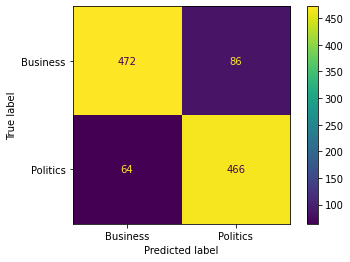

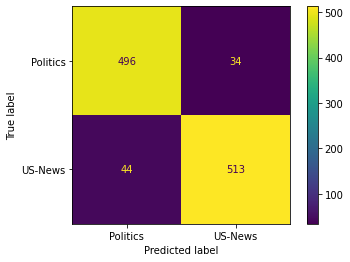

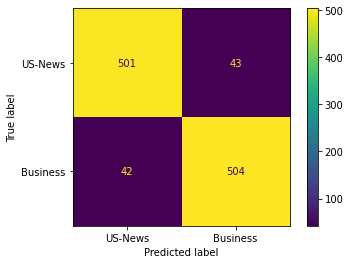

In [82]:
for i in range(0,3):
    bClassifier = TextClassifier(CATEGORIES[i%3], CATEGORIES[(i+1)%3])
    bClassifier.binary_run()

##### Discussion and Conclusion (Task 2):

The model performs the best on the classification of "Politics" and "US-News",
where Accuracy = , Precision = , Recall = , F1-measure =

We select xxx as our main criteria to examine the model
XXX has potential to improve the

---

### Task 3. Multi-Class Text Classification
1. Using all three categories (A,B,C) that you have selected:
    1. Apply appropriate preprocessing steps to create a numeric representation of the documents
    for these three categories, suitable for classification.
    2. Train a classification model using a multi-class classifier of your choice,
    which can distinguish documents from the categories A, B, and C.
    3. Test the predictions of the classification model using an appropriate evaluation strategy.
    Report and discuss the evaluation results.


Training set has 5440 documents. Target classes are {'Politics', 'Business', 'US-News'}
Vocabulary has 2032 distinct terms
A sample terms after preprocessing: From index 200 to 220, set: ['barr', 'barrett', 'bars', 'based', 'baseless', 'battle', 'battles', 'bbc', 'beat', 'began', 'begin', 'beginning', 'begins', 'begun', 'believe', 'ben', 'benefits', 'bernie', 'best', 'better']
A document-term matrix is constructed in a shape of (5440, 2032)
------------------------------
Start training...
Training set has 3808 examples
Test set has 1632 examples
Model has been trained!
------------------------------
Start evaluating...
Accuracy = 0.8909
              precision    recall  f1-score   support

    Business      0.859     0.871     0.865       552
    Politics      0.875     0.908     0.891       532
     US-News      0.942     0.894     0.918       548

    accuracy                          0.891      1632
   macro avg      0.892     0.891     0.891      1632
weighted avg      0.892     0

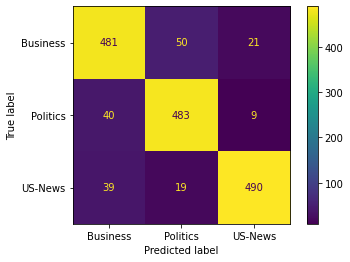

In [83]:
mClassifier = TextClassifier(isMulti=True)
mClassifier.multi_run()

##### Discussion and Conclusion (Task 3):